# Assignment 1: Social Data Analysis and Visualization

Group formed by Esben Kok, Sergi Lupon and Marta Arana

---
## **Part 1: Temporal Overview**

### ***Creation of the Rock Music Artist Network***

> #### *Draws from: Week 1, Exercises 4.1 and 4.2*

First of all, we need to import the preparatory functions to tailor the network, which most of them were already designed throughout Week4. The following code contains these functions, and some comments to properly understand how it works.

In [25]:

### IMPORTS
import re
import time
import requests
from urllib.parse import quote
from collections import Counter
from typing import List, Dict

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

HEADERS = {"User-Agent": "MyWikipediaClient/1.0 (sergi.luponsantacana@gmail.com)"}

### PREPARATORY FUNCTIONS TO CREATE THE NETWORK
# ---------- Function used to extract the raw wikitext (unrendered markup) of a Wikipedia page with title: 'title' ----------
def download_wikitext(title: str) -> str:
    url = "https://en.wikipedia.org/w/api.php"
    params = {
        "action": "query",
        "prop": "revisions",
        "rvprop": "content",
        "rvslots": "main",
        "format": "json",
        "formatversion": "2",
        "titles": title,
        "redirects": "1",
    }
    r = requests.get(url, params=params, headers=HEADERS, timeout=30)
    r.raise_for_status()
    data = r.json()
    page = data["query"]["pages"][0]
    if page.get("missing"):
        raise ValueError(f"Page not found: {title}")
    return page["revisions"][0]["slots"]["main"]["content"]


# ---------- Function used to extract the titles from the raw text of a Wikipedia page, after using the previous function 'download_wikitext' ----------
def extract_titles_from_wikitext(wikitext: str) -> list[dict]:
    BASE = "https://en.wikipedia.org/wiki/"
    pattern = r"\[\[([^\]|]+)(?:\|[^\]]+)?\]\]"
    titles = sorted(set(m.strip() for m in re.findall(pattern, wikitext)))
    lst = []
    for t in titles:
        if t != "AllMusic" and  t!= "Category:Lists of rock musicians" and t!="Category:Lists of rock musicians by subgenre" and t!= "rock music":
            path = t.replace(" ", "_")
            path = BASE + quote(path, safe=":/._~-")
            lst.append({"name": t, "url": path})
    return lst  ## The function returns list of dicts with {'name': title, 'url': full Wikipedia URL}


# ---------- Function to get rendered HTML of a Wikipedia page with title: 'title. It is a similar way of extracting the raw text of function '
def fetch_article_html(title: str) -> BeautifulSoup:   #Now this function represent fetch_wikipedia_page from original script in class 5 but more complete
    """
    It is a similar way of extracting raw text from a Wikipedia page of function 'download_wikitext'; however, this returns a Beautiful Soup instead of a string.
    In the next cell, this will be further clarified
    """
    api_url = "https://en.wikipedia.org/w/api.php"
    params = {
        "action": "parse",
        "page": title,
        "prop": "text",
        "format": "json",
        "formatversion": "2",
        "redirects": "1",
    }
    r = requests.get(api_url, params=params, headers=HEADERS, timeout=30)
    r.raise_for_status()
    data = r.json()
    if "error" in data:
        raise RuntimeError(f"MediaWiki error for '{title}': {data['error']}")
    html_content = data["parse"]["text"]
    return BeautifulSoup(f'<div class="mw-parser-output">{html_content}</div>', 'html.parser')


# ---------- This function computes the total number of words of a Wikipedia Page, once it has converted into a Beautiful Soup by means of function 'fetch_article_html' ----------
def count_words_on_page(soup: BeautifulSoup) -> int:
    """
    Count the number of words in the main article body.
    """
    content = soup.find('div', {'class': 'mw-parser-output'})
    if not content:
        return 0
    text = content.get_text()
    words = re.findall(r'\b\w+\b', text)
    return len(words)

- *Download_wikitext(title: str)*: Returns a string with the raw text contained in a Wikipedia Page
- *Fetch_article_html(title: str)*: Returns a Beautiful Soup with the raw text contained in a Wikipedia Page.

Both functions are similar in terms of their use and output. However, *Download_wikitext* is better suit to, subsequently, extract artists from the obtained raw text by using function *Extract_titles_from_wikitext(wikitext: str)*. By contrast, function *Fetch_article_html* is more suitable to compute the total number of words of a Wikipedia Page (focusing on the readable part of the Wikipedia website, which contains the most rellevant information from the artist)

Next, now that the preparatory functions have already been uploaded, we can proceed with creation of the network.

In [26]:
page_title = "List_of_mainstream_rock_performers"
wikitext = download_wikitext(page_title)
artists = extract_titles_from_wikitext(wikitext)
performer_names = {d["name"] for d in artists}

G = nx.DiGraph()
for i, src_item in enumerate(artists, 1):
    src = src_item["name"]
    src_url = src_item["url"]

    try:
        wt = download_wikitext(src)
        soup = fetch_article_html(src)
        word_count = count_words_on_page(soup)
        G.add_node(src, word_count=word_count, url=src_url)  #We add the node 'src = name of the artist', with the number of words and the url as node properties
        out_links = extract_titles_from_wikitext(wt)
        out_filtered = [d["name"] for d in out_links if d["name"] in performer_names and d["name"] != src]  #We extract the artists that are being referenced in this page, and that they were also mentioned in the "List_of_mainstream_rock_performers"
        G.add_edges_from((src, dst) for dst in out_filtered)
    except Exception as e:
        print(f"⚠️ Skipping {src}: {e}")
        continue
    if i % 25 == 0:
        print(f"Processed {i} / {len(artists)} artists")
        time.sleep(1)  # small pause to be polite

print(f"Graph built: {len(G.nodes)} nodes, {len(G.edges)} edges")

Processed 25 / 488 artists
Processed 50 / 488 artists
Processed 75 / 488 artists
Processed 100 / 488 artists
Processed 125 / 488 artists
Processed 150 / 488 artists
Processed 175 / 488 artists
Processed 200 / 488 artists
Processed 225 / 488 artists
Processed 250 / 488 artists
Processed 275 / 488 artists
Processed 300 / 488 artists
Processed 325 / 488 artists
Processed 350 / 488 artists
Processed 375 / 488 artists
Processed 400 / 488 artists
Processed 425 / 488 artists
Processed 450 / 488 artists
Processed 475 / 488 artists
Graph built: 488 nodes, 7387 edges


For this exercise, it is just needed the Giant Connected Component, and the undirected version of it:

In [28]:
isolates = [n for n in G.nodes if G.in_degree(n) == 0 and G.out_degree(n) == 0]  #obtain the isolated nodes (ktotal = 0)
G.remove_nodes_from(isolates)  #remove isolated nodes from the network
largest_cc_nodes = max(nx.weakly_connected_components(G), key=len)   #get the Gian Connected Component (component with the larger number of nodes)
G_lcc = G.subgraph(largest_cc_nodes).copy()  #Giant Connected Component of G
G_und = G_lcc.to_undirected()   #Undirected version
print(f"Final graph (GCC and undirected): {len(G_und.nodes)} nodes, {len(G_und.edges)} edges")

Final graph (GCC and undirected): 487 nodes, 6067 edges


---
### ***Visualization of the Rock Music Artist Network using ForceAtlas2 representation***

> * Visualize the network using ForceAtlas2
>   * Node color should depend on the `length_of_content` attribute (see notes from last week).
>   * Node size should depend on the node *degree*
> * Play with the force atlas algorithm parameters to obtain a visualization you like.



Now that the graph has been designed, we will proceed by plotting the network by using the recommended implementation of ForceAtlas2. Moreover, the parameters will be changed in order to obtain different visualizations of the graph and choose the most illustrative one

/usr/local/lib/python3.12/dist-packages/networkx/drawing/layout.py:1809: RuntimeWarning: invalid value encountered in divide
  attraction = -np.log(1 + distance) / distance


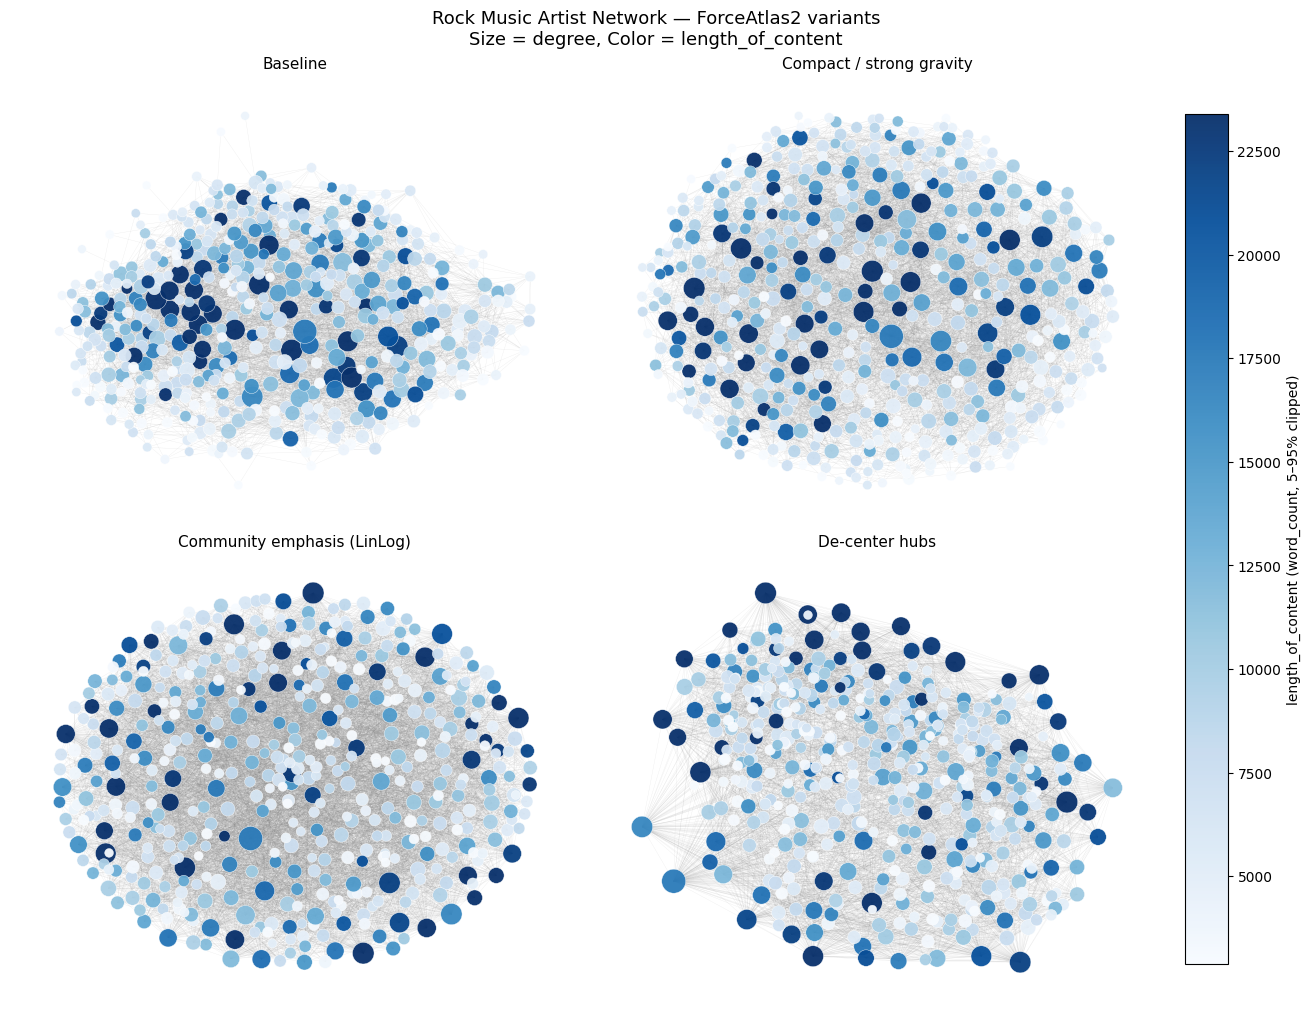

In [29]:
# Subplots comparing a few ForceAtlas2 settings (compact, clear, no overlaps)

# layout + encodings (computed once)
pos_kwargs = dict(max_iter=300, jitter_tolerance=1.0, seed=42)  # stable baseline knobs

deg = dict(G_und.degree())                                      # size = degree (readable range)
dvals = np.array([deg[n] for n in G_und.nodes()])
sizes = np.interp(dvals, (dvals.min(), dvals.max()), (40, 300))

wc = np.array([G_lcc.nodes[n].get("word_count", 0) for n in G_und.nodes()])  # color = word_count (robust scale)
vmin, vmax = np.percentile(wc, [5, 95]) if wc.size else (0, 1)
wc_clip = np.clip(wc, vmin, vmax)

# small set of layout variants to compare
configs = [
    ("Baseline", dict(scaling_ratio=2.0, gravity=1.0, distributed_action=False, strong_gravity=False, dissuade_hubs=False, linlog=False)),
    ("Compact / strong gravity", dict(scaling_ratio=1.5, gravity=2.5, strong_gravity=True, distributed_action=False, dissuade_hubs=False, linlog=False)),
    ("Community emphasis (LinLog)", dict(linlog=True, scaling_ratio=6.0, gravity=0.6, distributed_action=True, strong_gravity=False, dissuade_hubs=False)),
    ("De-center hubs", dict(scaling_ratio=4.0, gravity=1.2, distributed_action=True, dissuade_hubs=True, strong_gravity=False, linlog=False)),
]

# figure with constrained layout to prevent overlaps; shared colorbar on the right
fig, axes = plt.subplots(2, 2, figsize=(13, 10), layout="constrained")
axes = axes.ravel()
nodes_artist = None

for ax, (title, cfg) in zip(axes, configs):
    pos = nx.forceatlas2_layout(G_und, **pos_kwargs, **cfg)     # node positions with current FA2 variant
    nx.draw_networkx_edges(G_und, pos, width=0.25, alpha=0.15, edge_color="#888", ax=ax)  # light edges behind
    nodes_artist = nx.draw_networkx_nodes(                      # nodes colored by wc_clip, sized by degree
        G_und, pos, node_size=sizes, node_color=wc_clip, cmap="Blues",
        vmin=vmin, vmax=vmax, linewidths=0.3, edgecolors="white", alpha=0.95, ax=ax
    )
    ax.set_title(title, fontsize=11)
    ax.set_axis_off()

# shared colorbar
cbar = fig.colorbar(nodes_artist, ax=axes.tolist(), location="right", shrink=0.92, pad=0.02)
cbar.set_label("length_of_content (word_count, 5–95% clipped)")
fig.suptitle("Rock Music Artist Network — ForceAtlas2 variants\nSize = degree, Color = length_of_content", fontsize=13)
plt.show()

The analysis compares how different ForceAtlas2 parameter configurations influence the spatial structure of the *rock performers* network. Node attributes are encoded consistently across all visualizations to allow for direct comparison. Node size represents degree, which reflects how connected a node is within the network, while node color encodes `word_count`, indicating the relative content length. The color scale is restricted to the 5th–95th percentile range to avoid distortion from extreme outliers, and the same scale is applied to all subplots to maintain interpretability.

Each subplot corresponds to a distinct ForceAtlas2 configuration. The *Baseline* layout uses balanced default parameters, providing a neutral reference. The *Compact / galaxy* configuration increases gravity and enables strong gravity, producing a more centralized and dense structure. The *Community emphasis (LinLog)* configuration increases repulsion and activates LinLog mode while reducing gravity, leading to clearer separation between communities. The *De-center hubs* configuration enables distributed attraction and hub dissuasion, pushing highly connected nodes away from the center and highlighting peripheral star-like patterns.

The figure employs a constrained layout to ensure that subplots and the shared colorbar remain properly aligned without overlap. Equal axis scales are applied to all panels to facilitate fair visual comparison. Edges are drawn lightly in the background to avoid visual congestion, while nodes are given a white border to enhance contrast. The result is a clean, consistent, and analytically comparable set of ForceAtlas2 visualizations, allowing structural differences across parameter choices to be interpreted more clearly.








---
### ***Network analysis***
For this part, methods from week 4 and week 5 will be utilized to create an analysis of the network. Key questions we answer:
1. Is this network centralized around hubs or more distributed?
2. Who are the most important/influential artists?
3. Do well-connected artists link to each other or to peripheral ones?
4. What does the core structure look like?

##### NETWORK CHARACTERISTICS

In [30]:
print("NETWORK CHARACTERISTICS")
print("-" * 30)
print(f"Nodes (artists):     {G_lcc.number_of_nodes()}")
print(f"Edges (references):  {G_lcc.number_of_edges()}")
print(f"Density:             {nx.density(G_lcc):.3f}")
print(f"Avg in-degree:       {sum(dict(G_lcc.in_degree()).values()) / G_lcc.number_of_nodes():.2f}")
print(f"Avg out-degree:      {sum(dict(G_lcc.out_degree()).values()) / G_lcc.number_of_nodes():.2f}")

NETWORK CHARACTERISTICS
------------------------------
Nodes (artists):     487
Edges (references):  7387
Density:             0.031
Avg in-degree:       15.17
Avg out-degree:      15.17


The network is fairly sparse overall, with a density of about 0.03, meaning that only a small share of all possible artist-to-artist links actually appear. Still, artists have an average of around 15 incoming and outgoing connections, so most musicians reference a decent number of other musicians. The fact that the average in-degree and out-degree are the same simply reflects that every reference comes from someone and goes to someone else, so the overall flow of links is balanced.

##### DEGREE DISTRIBUTION

In [31]:
print("DEGREE DISTRIBUTION")
print("-" * 40)

in_degrees = [d for n, d in G_lcc.in_degree()]
out_degrees = [d for n, d in G_lcc.out_degree()]

print(f"In-degree range:  {min(in_degrees)} to {max(in_degrees)}")
print(f"Out-degree range: {min(out_degrees)} to {max(out_degrees)}")
print()

# Check for hubs (nodes with degree >> average)
avg_in = np.mean(in_degrees)
hubs_in = [n for n, d in G_lcc.in_degree() if d > 3 * avg_in]
print(f"Hub artists (in-degree > 3× average): {len(hubs_in)}")
print(f"Network is hub-dominated")

DEGREE DISTRIBUTION
----------------------------------------
In-degree range:  0 to 119
Out-degree range: 0 to 74

Hub artists (in-degree > 3× average): 33
Network is hub-dominated


The degree ranges show that there's a big difference between the most and least connected artists. Some musicians receive over 100 incoming links, while others barely get any. A few artists even have an in-degree or out-degree of zero, which can happen naturally, but it might also reflect web scraping errors when the network was created. When defining hubs as artists with more than three times the average in-degree, we find 33 of them. This confirms that the network is dominated by a relatively small group of highly referenced musicians rather than being evenly connected.

##### CENTRALITY: IDENTIFYING KEY ARTISTS

In [32]:
print("CENTRALITY: IDENTIFYING KEY ARTISTS")
print("-"*70)
print()

# Focus on the most meaningful measures for THIS network
print("Calculating in-degree centrality (who is most referenced)...")
in_degree_cent = nx.in_degree_centrality(G_lcc)

print("Calculating betweenness centrality (who are the bridges)...")
betweenness_cent = nx.betweenness_centrality(G_lcc)

# Top 10 by each
top_indegree = sorted(in_degree_cent.items(), key=lambda x: x[1], reverse=True)[:10]
top_betweenness = sorted(betweenness_cent.items(), key=lambda x: x[1], reverse=True)[:10]

print()
print("TOP 10 MOST REFERENCED ARTISTS (In-Degree Centrality)")
print("-" * 70)
for i, (artist, cent) in enumerate(top_indegree, 1):
    degree = G_lcc.in_degree(artist)
    print(f"{i:2}. {artist:<45} (referenced by {degree} artists)")

print()
print("TOP 10 BRIDGE ARTISTS (Betweenness Centrality)")
print("-" * 70)
for i, (artist, cent) in enumerate(top_betweenness, 1):
    print(f"{i:2}. {artist:<45} (betweenness: {cent:.4f})")

# Who appears in both?
top_in_set = {a for a, _ in top_indegree}
top_bet_set = {a for a, _ in top_betweenness}
overlap = top_in_set & top_bet_set

print()
print(f"Artists in BOTH top 10s: {len(overlap)}")
if overlap:
    for artist in sorted(overlap):
        print(f"  - {artist}")
print()

CENTRALITY: IDENTIFYING KEY ARTISTS
----------------------------------------------------------------------

Calculating in-degree centrality (who is most referenced)...
Calculating betweenness centrality (who are the bridges)...

TOP 10 MOST REFERENCED ARTISTS (In-Degree Centrality)
----------------------------------------------------------------------
 1. Led Zeppelin                                  (referenced by 119 artists)
 2. Bob Dylan                                     (referenced by 95 artists)
 3. Queen (band)                                  (referenced by 88 artists)
 4. Metallica                                     (referenced by 85 artists)
 5. David Bowie                                   (referenced by 85 artists)
 6. Jimi Hendrix                                  (referenced by 77 artists)
 7. Black Sabbath                                 (referenced by 75 artists)
 8. U2                                            (referenced by 74 artists)
 9. Kiss (band)             

To understand which artists matter most in the network, we looked at two different centrality measures. In-degree centrality highlights the musicians who are referenced the most, while betweenness centrality captures the ones that act as bridges between different parts of the network. The in-degree ranking is dominated by artists such as Led Zeppelin, Bob Dylan, Queen, and Metallica, which makes sense given their popularity and impact on rock music in general. The betweenness results tell a slightly different story: artists like Deep Purple and Alice in Chains show up as important connectors even if they are not the most referenced overall.

Six artists appear in both top-10 lists. These musicians are not only heavily referenced, but also play a key role in connecting different clusters of the network. This suggests that they have both broad influence and structural importance in how artists are linked to one another.

##### ASSORTATIVITY: MIXING PATTERNS

In [33]:
print("ASSORTATIVITY: MIXING PATTERNS")
print("-"*70)
print()

# Use undirected for assortativity (standard approach)
degree_assortativity = nx.degree_assortativity_coefficient(G_und)

print(f"Degree assortativity coefficient: {degree_assortativity:.4f}")


ASSORTATIVITY: MIXING PATTERNS
----------------------------------------------------------------------

Degree assortativity coefficient: 0.0071


To check whether highly connected artists tend to link to other highly connected artists, we calculated the degree assortativity of the network. The value is close to zero (0.007), which means there is basically no clear pattern in how nodes connect based on degree. In other words, popular artists are not especially more likely to link to other popular artists, nor do they avoid them. The mixing appears mostly random with respect to degree.

##### NETWORK BACKBONE EXTRACTION

In [34]:
print("NETWORK BACKBONE EXTRACTION")
print("-"*70)
print()

print("Calculating edge betweenness centrality:")
edge_betweenness = nx.edge_betweenness_centrality(G_lcc)

# Sort edges by betweenness
sorted_edges = sorted(edge_betweenness.items(), key=lambda x: x[1], reverse=True)

# Keep top 15% of edges (adjust this percentage as needed for good visualization)
backbone_percentage = 0.15
n_edges_backbone = int(len(sorted_edges) * backbone_percentage)
backbone_edges = [edge for edge, _ in sorted_edges[:n_edges_backbone]]

# Create backbone graph
G_backbone = nx.Graph()
G_backbone.add_edges_from(backbone_edges)

# Remove isolated nodes
isolated = list(nx.isolates(G_backbone))
G_backbone.remove_nodes_from(isolated)

print(f"Original network: {G_lcc.number_of_nodes()} nodes, {G_lcc.number_of_edges()} edges")
print(f"Backbone (top {backbone_percentage*100:.0f}% edges): {G_backbone.number_of_nodes()} nodes, {G_backbone.number_of_edges()} edges")
print(f"Edges removed: {G_lcc.number_of_edges() - G_backbone.number_of_edges()} ({(1-backbone_percentage)*100:.0f}%)")
print(f"Nodes in backbone: {G_backbone.number_of_nodes()} ({G_backbone.number_of_nodes()/G_lcc.number_of_nodes()*100:.1f}%)")
print()

# Check connectivity of backbone
if nx.is_connected(G_backbone):
    print("Backbone is connected")
else:
    components = list(nx.connected_components(G_backbone))
    print(f"Backbone has {len(components)} components")
    print(f"Largest component: {len(max(components, key=len))} nodes")

NETWORK BACKBONE EXTRACTION
----------------------------------------------------------------------

Calculating edge betweenness centrality:
Original network: 487 nodes, 7387 edges
Backbone (top 15% edges): 466 nodes, 1071 edges
Edges removed: 6316 (85%)
Nodes in backbone: 466 (95.7%)

Backbone is connected


To get a better look at the main structure of the network, we extracted a backbone using edge betweenness centrality. The idea is that edges with high betweenness are the ones most “important” for holding the network together, so keeping only the top 15% of them should reveal the core without all the extra noise. After filtering, the backbone still contains almost all the artists (about 96%), but only a fraction of the original edges. This shows that most of the meaningful connectivity is carried by a relatively small set of important links. The backbone also remains fully connected, which means the core structure of the network stays intact even after removing the majority of edges.

##### NETWORK BACKBONE VISUALIZATION

(np.float64(-271.1662063598633),
 np.float64(251.2023696899414),
 np.float64(-260.1304130554199),
 np.float64(227.13512802124023))

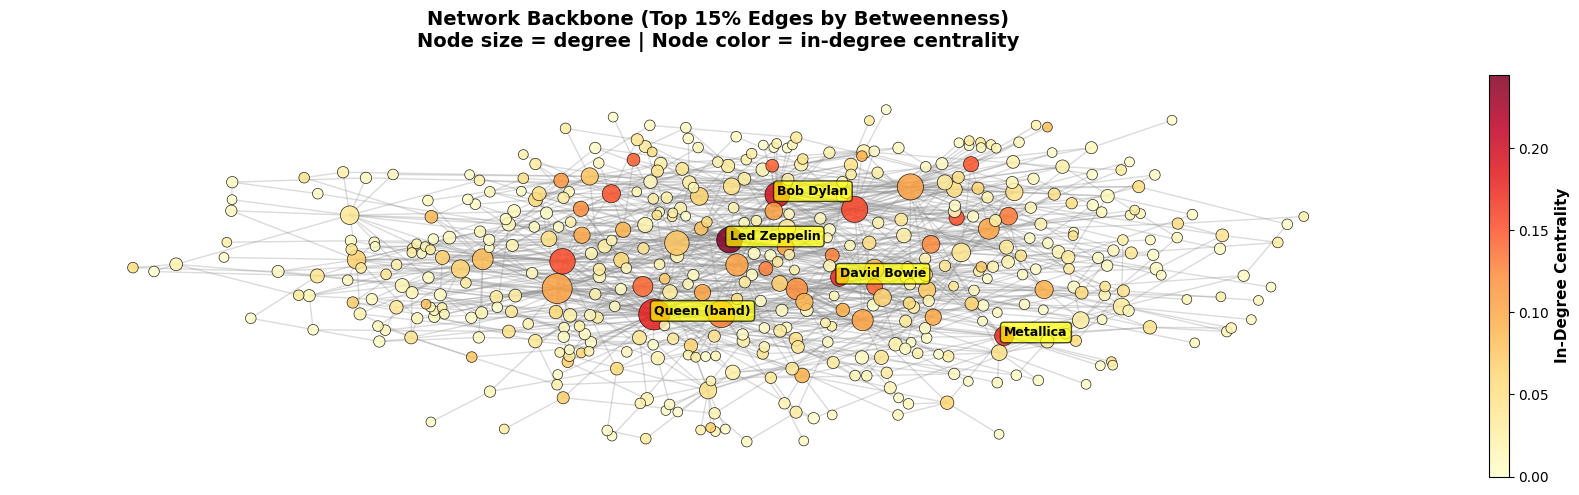

In [35]:
#Network Backbone Visualization
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

ax4 = fig.add_subplot(gs[1, :])

pos = nx.forceatlas2_layout(G_backbone, max_iter=300, seed=42)

# Node sizes based on degree in backbone
backbone_degrees = dict(G_backbone.degree())
sizes = np.array([backbone_degrees[n] for n in G_backbone.nodes()])
sizes_scaled = np.interp(sizes, (sizes.min(), sizes.max()), (50, 500))

# Node colors based on in-degree centrality in original network
colors = [in_degree_cent.get(n, 0) for n in G_backbone.nodes()]

# Draw edges
nx.draw_networkx_edges(G_backbone, pos, width=1.0, alpha=0.3, edge_color='#888888', ax=ax4)

# Draw nodes
nodes = nx.draw_networkx_nodes(
    G_backbone, pos,
    node_size=sizes_scaled,
    node_color=colors,
    cmap='YlOrRd',
    alpha=0.85,
    edgecolors='black',
    linewidths=0.5,
    ax=ax4
)

# Add colorbar
cbar = plt.colorbar(nodes, ax=ax4, fraction=0.046, pad=0.04)
cbar.set_label('In-Degree Centrality', fontsize=11, fontweight='bold')

# Label top 5 most central nodes in backbone
top_in_backbone = sorted([(n, in_degree_cent.get(n, 0)) for n in G_backbone.nodes()],
                         key=lambda x: x[1], reverse=True)[:5]
for artist, _ in top_in_backbone:
    if artist in pos:
        ax4.annotate(artist, pos[artist], fontsize=9, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

ax4.set_title(f'Network Backbone (Top {backbone_percentage*100:.0f}% Edges by Betweenness)\n' +
              f'Node size = degree | Node color = in-degree centrality',
              fontsize=14, fontweight='bold', pad=20)
ax4.axis('off')

The backbone visualization highlights the main structure of the network once the less important edges are removed. Larger nodes represent artists with higher degree in the backbone, and the warmer colors show higher in-degree centrality from the full network. The well-known artists that showed up earlier continue to stand out clearly here, both in size and color. This fits with the idea that they are not only heavily referenced but also sit in central positions that help hold the network together. Overall, the backbone makes it easier to see the core group of artists who play the biggest structural role in connecting the rest of the network.

##### BACKBONE STRUCTURE ANALYSIS

In [36]:
print("BACKBONE STRUCTURE ANALYSIS")
print("-"*70)
print()

# Centrality of backbone nodes
backbone_in_cents = [(n, in_degree_cent.get(n, 0)) for n in G_backbone.nodes()]
backbone_in_cents_sorted = sorted(backbone_in_cents, key=lambda x: x[1], reverse=True)

print("TOP 10 ARTISTS IN BACKBONE (by original in-degree centrality):")
print("-" * 70)
for i, (artist, cent) in enumerate(backbone_in_cents_sorted[:10], 1):
    print(f"{i:2}. {artist:<45} (centrality: {cent:.4f})")
print()

# Backbone connectivity
if nx.is_connected(G_backbone):
    diameter = nx.diameter(G_backbone)
    avg_path = nx.average_shortest_path_length(G_backbone)
    print(f"Backbone diameter: {diameter}")
    print(f"Backbone avg path length: {avg_path:.2f}")

print(f"Backbone density: {nx.density(G_backbone):.6f}")
print(f"Original network density: {nx.density(G_lcc):.6f}")
print(f"Backbone is {nx.density(G_backbone)/nx.density(G_lcc):.1f}x more dense")
print()

BACKBONE STRUCTURE ANALYSIS
----------------------------------------------------------------------

TOP 10 ARTISTS IN BACKBONE (by original in-degree centrality):
----------------------------------------------------------------------
 1. Led Zeppelin                                  (centrality: 0.2449)
 2. Bob Dylan                                     (centrality: 0.1955)
 3. Queen (band)                                  (centrality: 0.1811)
 4. Metallica                                     (centrality: 0.1749)
 5. David Bowie                                   (centrality: 0.1749)
 6. Jimi Hendrix                                  (centrality: 0.1584)
 7. Black Sabbath                                 (centrality: 0.1543)
 8. U2                                            (centrality: 0.1523)
 9. Nirvana (band)                                (centrality: 0.1502)
10. Kiss (band)                                   (centrality: 0.1502)

Backbone diameter: 6
Backbone avg path length: 3.47
Bac

The backbone structure mostly confirms what the earlier analysis showed: the same major artists dominate the core of the network. Led Zeppelin, Bob Dylan, Queen, Metallica, and David Bowie remain at the top when looking at in-degree centrality within the backbone, which means that even after removing most edges, the most influential artists are still the ones holding the core together. The backbone is also fairly compact, with a diameter of 6 and an average path length of about 3.5, so it doesn't take many steps to move between any two artists in this reduced structure. Even though the backbone has much fewer edges overall, the density actually drops compared to the full network, which makes sense since we kept only a small set of the most important connections. Overall, the backbone provides a cleaner view of the central group of artists that tie the whole network together.

##### SUMMARY

In [37]:
# SUMMARY
print("KEY FINDINGS SUMMARY")
print("-"*70)
print()
print(f"1. NETWORK STRUCTURE: {G_lcc.number_of_nodes()} artists, {G_lcc.number_of_edges()} references")
print(f"   - 'Hub-dominated' structure with {len(hubs_in)} hub artists")
print()
print(f"2. MOST INFLUENTIAL: {top_indegree[0][0]}")
print(f"   - Referenced by {G_lcc.in_degree(top_indegree[0][0])} other artists")
print()
print(f"3. KEY BRIDGE: {top_betweenness[0][0]}")
print(f"   - Connects different parts of the network")
print()
print(f"4. MIXING PATTERN: {interpretation.split(':')[0]}")
print(f"   - Assortativity coefficient: {degree_assortativity:.4f}")
print()
print(f"5. HUB-BRIDGE OVERLAP: {len(overlap)}/10 artists are both highly referenced AND bridges")
print()
print(f"6. NETWORK BACKBONE: {G_backbone.number_of_nodes()} artists, {G_backbone.number_of_edges()} core connections")
print(f"   - Reveals {len(list(nx.connected_components(G_backbone)))} main structural component")
print(f"   - Core is {nx.density(G_backbone)/nx.density(G_lcc):.1f}x more densely connected than full network")

KEY FINDINGS SUMMARY
----------------------------------------------------------------------

1. NETWORK STRUCTURE: 487 artists, 7387 references
   - 'Hub-dominated' structure with 33 hub artists

2. MOST INFLUENTIAL: Led Zeppelin
   - Referenced by 119 other artists

3. KEY BRIDGE: Deep Purple
   - Connects different parts of the network



NameError: name 'interpretation' is not defined

Overall, the network of rock artists turns out to be strongly centered around a group of well-known hubs. The top most popular artists receive far more references than most others, and several of them also act as bridges between different parts of the network. The network shows almost no assortativity, meaning that highly connected artists don't especially prefer linking to other highly connected ones. When extracting the backbone, the core structure stays intact and is still dominated by the same major artists, even though most edges are removed. The backbone forms one main connected component, showing that the central part of the network is held together by a small set of influential musicians. Altogether, the analysis paints a consistent picture of a hub-dominated network where a handful of major rock artists play a significant role, both by the number of references to them and by them acting as bridges between others.

---
## **Part 2: Genres and communities plotting**

### ***Extraction of the genres from the Infobox of every artist in the network***

> * Crete a dictionary mapping artist names to lists of genres (since most artists have multiple genres listed)

The first step is to create some supplementary functions to help us obtain the list of genres for each artist. Next cell contains these functions, with a little explanation of them:

In [38]:
### SUPPLEMENTARY FUNCTIONS TO EXTRACT GENRES FOR EACH ARTIST

# ---------- Auxiliary function used inside `extract_genres_from_infobox` ----------
def _normalize_genre(g: str) -> str:
    """
    Helper function that standardizes genre strings extracted from Wikipedia infoboxes.
    The goal is to remove inconsistencies such as references, formatting symbols,
    and stylistic variations, producing a clean and comparable genre label.
    """
    g = g.lower().strip()

    # Inline references and notes such as [1], [note 2], or [citation needed] are removed
    g = re.sub(r"\[[^\]]+\]", "", g).replace("citation needed", "").strip()

    # Variations of 'rock 'n' roll' are unified under the normalized form 'rock and roll'
    g = re.sub(r"rock\s*['’&]?\s*n\s*['’]?\s*roll", "rock and roll", g, flags=re.IGNORECASE)

    # Bullets, dashes, and non-breaking spaces are collapsed into single spaces
    g = re.sub(r"[·•–—|\u00A0]+", " ", g)
    g = re.sub(r"\s+", " ", g).strip()

    # Tokens that consist only of parentheses (e.g. "(early)") are discarded
    if re.fullmatch(r"\([^)]*\)", g):
        return ""

    # Qualifiers placed at the end between parentheses are removed, e.g. "punk rock (early)" → "punk rock"
    g = re.sub(r"\s*\([^)]*\)\s*$", "", g).strip()

    # Any remaining punctuation is trimmed from both ends
    g = g.strip(",.;: []")

    return g


def extract_genres_from_infobox(soup: BeautifulSoup) -> List[str]:
    """
    Extracts the list of musical genres from the infobox of a Wikipedia page.
    The procedure identifies the 'Genre' or 'Genres' row, cleans the extracted content,
    and returns a normalized, de-duplicated list of genre labels.

    The extraction process follows these main steps:
    1) Locate the infobox and identify the 'Genre/Genres' entry.
    2) Remove all reference tags and citation markers that appear as superscripts.
    3) Extract anchor text (<a> tags) since these usually contain canonical genre names.
    4) Retrieve remaining plain text from the cell, preserving line breaks as separators.
    5) Split the text by common delimiters but avoid splitting by the conjunction 'and'
       to maintain the integrity of phrases like 'rock and roll'.
    6) Normalize each genre string using `_normalize_genre` and remove duplicates
       while preserving the order of appearance.
    """
    # The infobox table is located by identifying a <table> element whose class includes 'infobox'
    infobox = soup.find("table", class_=lambda c: c and "infobox" in c)
    if not infobox:
        return []

    # Each table row (<tr>) is checked to find the one corresponding to 'Genre' or 'Genres'
    for row in infobox.find_all("tr"):
        th = row.find("th")
        if not th:
            continue
        label = th.get_text(strip=True).lower()
        if label in {"genre", "genres"}:
            td = row.find("td")
            if not td:
                return []

            # All reference elements (<sup class="reference"> or <span class="reference">)
            # are removed from the cell to ensure cleaner text extraction
            for el in td.select("sup.reference, span.reference"):
                el.decompose()

            # Anchor elements (<a>) are extracted first, since these tend to provide
            # standardized genre names and are less noisy than plain text
            links = []
            for a in td.find_all("a"):
                href = a.get("href") or ""
                if href.startswith("#cite_note"):
                    continue
                links.append(a.get_text(" ", strip=True))

            # The full text is then retrieved from the cell, using line breaks as separators.
            # Variants of 'rock 'n' roll' are again normalized before splitting.
            raw_text = td.get_text("\n", strip=True)
            raw_text = re.sub(
                r"rock\s*['’&]?\s*n\s*['’]?\s*roll",
                "rock and roll",
                raw_text,
                flags=re.IGNORECASE,
            )

            # The text is split by standard delimiters such as commas, slashes, semicolons,
            # bullets, pipes, or line breaks. The word 'and' is deliberately ignored
            # to avoid incorrect splits in compound genre names.
            parts = re.split(r"(?:,|/|;|\n|·|•|\|)+", raw_text)

            # The anchor-based list and the split text are merged as potential genre candidates
            candidates = links + parts

            # Each candidate is normalized and added only once, maintaining the order
            seen, genres = set(), []
            for x in candidates:
                g = _normalize_genre(x)
                if g and g not in seen:
                    seen.add(g)
                    genres.append(g)

            return genres

    # If the infobox or the genre row is not found, an empty list is returned
    return []

Below, it is created the dictionary 'artist_genres' containing a list of the genres linked to every artist

In [39]:
### EXTRACTION OF THE GENRES FOR EACH ARTIST
artist_genres = {}  # Dictionary that will contain the list of genres for each artist
for art in performer_names: #Iterating for every artist in the list of artists
    try:
        soup = fetch_article_html(art)  #Output: BeautifulSoup with the raw text of the Wikipedia Page
        genres = extract_genres_from_infobox(soup)  #Output: List with the genres for the artist
        if genres:
            artist_genres[art] = genres   #Updates the dictionary with the information
    except Exception as e:
        print(f"⚠️ Skipping {art}: {e}")
        continue

print(f"\n Genres found for {len(artist_genres)} artists")
artist_genres


 Genres found for 488 artists


{'The Cars': ['new wave', 'power pop', 'pop rock', 'synth-rock'],
 'Robert Plant': ['rock',
  'blues',
  'folk',
  'country',
  'hard rock',
  'heavy metal'],
 'Poison (American band)': ['glam metal', 'hard rock', 'heavy metal'],
 'Run-DMC': ['hip-hop', 'rap rock'],
 'The Alan Parsons Project': ['progressive rock',
  'art rock',
  'progressive pop',
  'soft rock'],
 'Tenacious D': ['comedy rock', 'acoustic rock', 'hard rock', 'heavy metal'],
 'Sting (musician)': ['pop', 'new wave', 'post-punk', 'soft rock'],
 'Weezer': ['alternative rock',
  'power pop',
  'pop rock',
  'geek rock',
  'pop-punk',
  'emo'],
 'The Doors': ['psychedelic rock', 'blues rock', 'acid rock'],
 'Bad Company': ['hard rock', 'blues rock'],
 'The Band': ['roots rock', 'americana', 'folk rock', 'country rock'],
 'Jefferson Starship': ['rock',
  'hard rock',
  'psychedelic rock',
  'progressive rock',
  'soft rock'],
 'The Smashing Pumpkins': ['alternative rock'],
 'Boys Like Girls': ['pop rock', 'pop-punk', 'emo po

> * Report the following stats
>   * The number of nodes for which you could find genres
>   * The average number of genres per node
>   * The total number of distinct genres
>   * A histogram showing artist counts for the top 15 genres

Number of nodes with genres: 488
Average number of genres per node: 3.95
Total number of distinct genres: 210


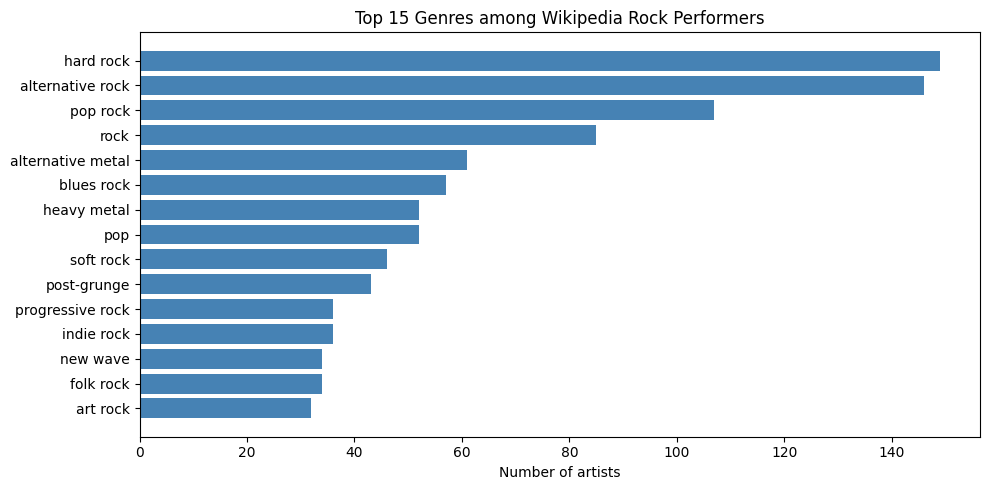

In [40]:
all_genres = [g for glist in artist_genres.values() for g in glist]
genre_counts = Counter(all_genres)

num_nodes_with_genre = len(artist_genres)
avg_genres_per_node = np.mean([len(v) for v in artist_genres.values()])
distinct_genres = len(genre_counts)

print(f"Number of nodes with genres: {num_nodes_with_genre}")
print(f"Average number of genres per node: {avg_genres_per_node:.2f}")
print(f"Total number of distinct genres: {distinct_genres}")

# ---------- 9. Plot top 15 genres ----------
top15 = genre_counts.most_common(15)
genres, counts = zip(*top15)

plt.figure(figsize=(10, 5))
plt.barh(genres[::-1], counts[::-1], color="steelblue")
plt.xlabel("Number of artists")
plt.title("Top 15 Genres among Wikipedia Rock Performers")
plt.tight_layout()
plt.show()

Using the extracted genre lists, genres were identified for 488 artists. The mean coverage is 3.95 genres per artist, indicating that artists are typically tagged with multiple styles. In total, 210 distinct genres were observed. The histogram in the cell above summarizes the top 15 genres by artist count; the distribution is headed by hard rock and alternative rock, followed by pop rock and rock, with a long tail of styles (e.g., alternative metal, blues rock, heavy metal). This pattern suggests a small set of dominant labels alongside substantial stylistic diversity across the corpus.

---
### ***Concept of Modularity and Genre-Based Community Structure***

> * Explain the concept of modularity in your own words

**Modularity** ($M$) measures how well a network is divided into communities — that is, how strongly nodes within the same group are connected **to each other** compared to connections **between** groups.

Intuitively:
- A high modularity means many edges fall *inside* communities and few between them.
- A low (or negative) modularity means the partition is weak — the edges connect groups at random.

Formally (see *Network Science*, Section 9.4):

$$
M = \frac{1}{2L} \sum_{i,j} \Big( A_{ij} - \frac{k_i k_j}{2L} \Big)\, \delta(c_i, c_j)
$$

where:
- $A_{ij}$ = adjacency matrix (1 if nodes *i* and *j* are connected, 0 otherwise)  
- $k_i$ = degree of node *i*  
- $L$ = total number of edges in the network  
- $\delta(c_i, c_j)$ = 1 if nodes *i* and *j* belong to the same community, else 0  

An equivalent (and computationally simpler) form is:

$$
M = \sum_c \left( \frac{L_c}{L} - \left( \frac{k_c}{2L} \right)^2 \right)
$$

where:
- $L_c$ = number of edges *within* community $c$  
- $k_c$ = sum of degrees of all nodes in community $c$  

The modularity ranges approximately between -1 and 1, where **values close to 1** indicate strong community structure. There, modularity also serves to decide which of the many partitions predicted by a hierarchical method offers the best community structure, selecting the one for which M is maximal.

> * Work from the undirected version of the network, keeping only the nodes for which you have genre information.
> * Now create your own partition of the network into genres.
>      * **Each node is simply characterized by the *first genre* in its list of genres**.
>      * Each community is the group of nodes that share the same genre.
>      * That's all you need, now calculate the modularity of this division of the network into genres.
>      * **Note**: Modularity is described in the _Network Science_ book, section 9.4.. Thus, use **equation 9.12** in the book to calculate the modularity $M$ of the partition described above. Are the genres good communities?

First thing, we need to modify the graph in order to obtain a version that only contains the nodes for which we have genre information. Moreover, the cell below also contains an auxiliar function to compute the modularity by means of the **Equation 9.12** from _Network Science_ book, section 9.4

In [41]:
import random
import math
from collections import defaultdict, Counter

##Keep only nodes with at least one genre assigned
keep = [n for n in G_und.nodes() if n in artist_genres and artist_genres[n]]
G_sub = G_und.subgraph(keep).copy()  #network with the nodes that have at least one genre assigned
print(f"Nodes with genres in G_und: {len(G_sub.nodes())}  |  Edges: {len(G_sub.edges())}")

## Function to compute modularity
def modularity_eq_9_12(G_sub, partition):
    """
    Computes modularity for an undirected, unweighted graph using the formula:
        M = Σ_c [ (L_c / m) - ( (d_c / (2m))^2 ) ]
    where:
        - m  = total number of edges in the graph
        - L_c = number of edges within community c
        - d_c = sum of node degrees in community c
    """
    m = G_sub.number_of_edges()

    # communities: label -> set(nodes)
    comm_nodes = defaultdict(set)
    for n, c in partition.items():
        comm_nodes[c].add(n)

    # L_c: count of internal edges per community
    L = Counter()
    # d_c: total degree per community
    dsum = Counter()

    deg = dict(G_sub.degree())

    for c, nodes in comm_nodes.items():
        # sum of degrees for each community
        dsum[c] = sum(deg[n] for n in nodes)

    # count internal edges (edges where both endpoints share the same community)
    for u, v in G_sub.edges():
        cu = partition.get(u)
        cv = partition.get(v)
        if cu is not None and cu == cv:  # only count if both nodes belong to the same community
            L[cu] += 1  # each internal edge contributes once

    # apply the modularity formula (aggregate over communities)
    M = 0.0
    for c in comm_nodes:
        Lc = L[c]
        dc = dsum[c]
        M += (Lc / m) - ((dc / (2 * m)) ** 2)
    return M

Nodes with genres in G_und: 487  |  Edges: 6067


Next, a network partition is created by assigning each node to the community corresponding to its first listed genre. Subsequently, we will compute the value of the modularity according to this first-genre partition of the network and some other rellevant statistics

In [42]:
##Partition from first-genre assignment
part_first = {}
for n in G_sub.nodes():
    g = artist_genres.get(n, [])
    if g:
        part_first[n] = g[0]  # first genre assigned

## Compute modularity for first-genre partition
M_first = modularity_eq_9_12(G_sub, part_first)
print(f"Modularity (first genre)): {M_first:.4f}")

## Some other community statistics
comms = defaultdict(list)
for n, c in part_first.items():
    comms[c].append(n)

sizes = sorted(((c, len(v)) for c, v in comms.items()), key=lambda x: x[1], reverse=True)
print(f"Number of communities (genres): {len(sizes)}")
print("Top 10 communities by size:")
for c, s in sizes[:10]:
    print(f"  {c:25s}  {s:5d}")

Modularity (first genre)): 0.0927
Number of communities (genres): 81
Top 10 communities by size:
  rock                          73
  alternative rock              63
  hard rock                     50
  pop rock                      20
  heavy metal                   16
  progressive rock              16
  rock and roll                 15
  alternative metal             13
  new wave                      12
  post-grunge                   11


The modularity of the genre-based partition, computed using Equation 9.12 from Network Science (section 9.4), was found to be **M = 0.0927**.

The obtained modularity value suggests that genres do not strongly align with the actual community structure of the Rock Artist Music Network. Although there is some tendency for artists of the same genre to be more connected, the effect is limited. This outcome is consistent with the nature of musical collaborations and stylistic overlap, where many artists belong to multiple genres, and connections often cross stylistic boundaries.

In total, **81 genre-based communities** were detected, with the largest including artists labeled as rock (73 nodes), alternative rock (63), and hard rock (50). The long tail of smaller genre groups (e.g., new wave, post-grunge) further indicates a fragmented distribution rather than a small set of tightly bound clusters. Another interesting thing that can be observed is that rock styles clearly dominates the ranking of communities sorted by size, which be further assesed in the next question.

Overall, the low modularity value implies that genres provide only a weak approximation of the underlying community structure in the network. The network is more interconnected across genre boundaries than would be expected in a clearly modular system, suggesting that musical collaboration and influence often transcend single-genre classifications.

>  * What happens to the modularity if you use a random genre from the list genre as the node-label for those nodes with more than one genre listed?What happens to the modularity if you use a random genre from the list genre as the node-label for those nodes with more than one genre listed?

Now, we will proceed to create another partition of the network based on the genres of each artist, but this time selecting a random genre from the artist list of genres instead of the first one. Moreover, we will run many iterations in ordain to capture the mean and deviation of the modularity due to the randomness.

In [43]:
## Modularity for random genre assignment

T = 50
rng = random.Random(42)

vals = []
for _ in range(T):
    # build a random-genre partition for nodes in G_sub
    part_rand = {}
    for n in G_sub.nodes():
        gl = artist_genres.get(n, [])
        part_rand[n] = rng.choice(gl)

    # modularity for this random labeling
    m_val = modularity_eq_9_12(G_sub, part_rand)
    vals.append(m_val)

# summary stats
mean_rand = sum(vals) / T
std_rand = (sum((x - mean_rand) ** 2 for x in vals) / T) ** 0.5

print(f"Modularity with random selected genre (mean ±std, {T} iterations): {mean_rand:.4f} ± {std_rand:.4f}")

Modularity with random selected genre (mean ±std, 50 iterations): 0.0371 ± 0.0037


The first genre listed in each artist’s Wikipedia infobox is typically the one considered most representative by contributors. Since the dataset originates from pages related to rock performers, this field often contains rock or one of its many subgenres (e.g., hard rock, alternative rock, pop rock). As a result, assigning each node to its first listed genre introduces a structural bias: a disproportionately large community labeled “rock” emerges, while smaller subgenres remain fragmented. When the assignment is randomized among the available genres for multigenre artists, this dominant effect is reduced, but modularity decreases further (now the modularity has decreased to a mean value of 0.0371 < 0,0927). This confirms that genre labels —and especially the ordering of genres in Wikipedia infoboxes— only weakly capture the true community structure of the network, as artists frequently bridge multiple closely related rock substyles.

> * Discuss your findings - and decide how you want to settle on a single genre for each band.  

In summary, using the first listed genre to define communities produced a low modularity, indicating that genre labels—especially the many variants of rock do not align strongly with densely intra-connected groups, while randomly assigning a genre for multigenre artists reduced modularity further. Overall, genres provide only a weak community signal in this network.

Given the exercise constraints and the need for a single, reproducible label per artist, the partition is settled using the first listed genre (deterministic and aligned with infobox primacy).

---
### ***Detection and Analysis of Structural Communities Using the Louvain Algorithm***

> * Use the Louvain-algorithm to find communities for the network. What is the modularity of this partitioning of the network? Is it more community-like than the genres? What does this comparison reveal about the communities?

In this exercise, the focus shifts from genre-based communities—which rely on metadata—to structural communities that emerge directly from the network’s topology. By applying the Louvain algorithm for community detection, the aim is to evaluate whether the network’s internal connectivity patterns reveal more cohesive and meaningful group structures than those defined by musical genres. The cell below simulates community detection by means of the Louvain algorithm, and computes the value of the modularity by using the previously defined auxiliar function *modularity_eq_9_12*


In [44]:
###LOUVAIN ALGORITHM + MODULARITY
from networkx.algorithms.community import louvain_communities
from collections import defaultdict

# 1) Run Louvain (unweighted graph)
#    Returns a list of sets, each set = nodes in one community
louvain_comms = louvain_communities(G_sub, seed=42)  # deterministic seed, G_sub is the subnetwork of nodes that have at least one genre

# 2) Convert to a node -> community-label dict
comm_label = {}
for idx, S in enumerate(louvain_comms):
    for n in S:
        comm_label[n] = idx  #node n pertains to community idx

# 3) Compute modularity of the Louvain partition with Eq. 9.12
M_louvain = modularity_eq_9_12(G_sub, comm_label)
print(f"Louvain: {len(louvain_comms)} communities | modularity = {M_louvain:.4f}")

Louvain: 5 communities | modularity = 0.3363


The modularity of the Louvain partition is 0.3363, which is clearly higher than the modularity obtained with the genre-based division (=0.0927). This means the network’s structural communities are much stronger and more internally connected than the groups defined by musical genres. In other words, the way artists are linked in the network reflects patterns of collaboration or similarity that go beyond genre labels. It suggests that artists tend to cluster based on structural relationships rather than strictly by their listed musical style.

> * Visualize the network, using the Force Atlas algorithm.
>     * This time assign each node a different color based on its structural _community_.
>     * **Note**: If there's a lot of small communities, it's OK to only color the 5-10 largest communities (you can make the remaing nodes light gray or some netural color)
>     * Describe the structure you observe.

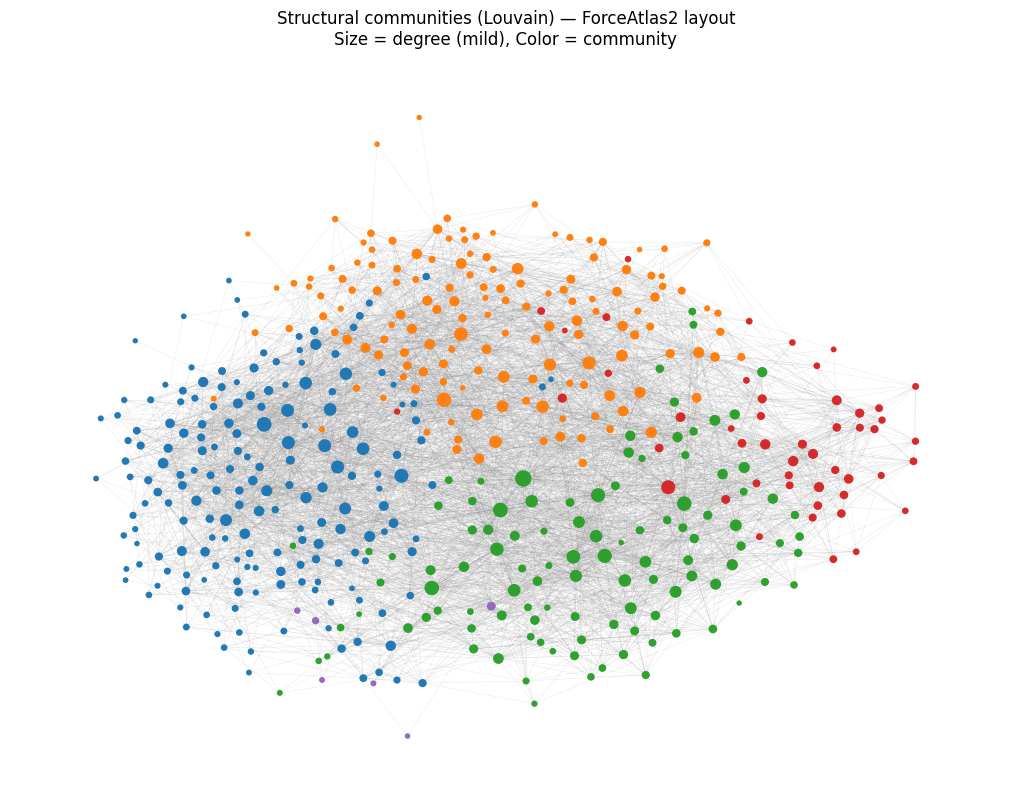

In [45]:
import matplotlib.colors as mcolors
pos = nx.forceatlas2_layout(
    G_sub,
    max_iter=300,
    jitter_tolerance=1.0,
    scaling_ratio=2.0,
    gravity=1.0,
    distributed_action=False,
    strong_gravity=False,
    dissuade_hubs=False,
    linlog=False,
    seed=42
)

# --- Node sizes: mild degree scaling for readability (hubs visible, clutter limited) ---
deg = dict(G_sub.degree())
dvals = np.array([deg[n] for n in G_sub.nodes()])
# Keep a narrow range; tweak (min_px, max_px) if needed.
sizes = np.interp(dvals, (dvals.min(), dvals.max()), (15, 140)) if dvals.size else 20

# --- Community colors: top-K in distinct colors, others gray ---
K = 8
sizes_by_comm = sorted(((i, len(S)) for i, S in enumerate(louvain_comms)),
                       key=lambda x: x[1], reverse=True)
largest_ids = {cid for cid, _ in sizes_by_comm[:K]}

distinct_colors = list(mcolors.TABLEAU_COLORS.values())  # 10 strong distinct colors
id_to_idx = {cid: idx for idx, (cid, _) in enumerate(sizes_by_comm[:K])}
node_colors = []
for n in G_sub.nodes():
    cid = comm_label[n]
    if cid in largest_ids:
        color = distinct_colors[id_to_idx[cid] % len(distinct_colors)]
        node_colors.append(color)
    else:
        node_colors.append((0.82, 0.82, 0.82, 0.75))  # light gray

# --- Draw (edges light; nodes on top) ---
plt.figure(figsize=(10, 8), layout="constrained")
nx.draw_networkx_edges(G_sub, pos, width=0.25, alpha=0.25, edge_color="#888")
nx.draw_networkx_nodes(G_sub, pos, node_size=sizes, node_color=node_colors,
                       linewidths=0, alpha=0.98)
plt.title("Structural communities (Louvain) — ForceAtlas2 layout\nSize = degree (mild), Color = community")
plt.axis("off")
plt.show()

The visualization shows four main structural communities that are clearly separated but still connected through a dense central area. Each color represents a distinct cluster of artists that are more connected within their group than to the rest of the network. The blue and orange communities form the largest and most cohesive parts, while the green and red ones occupy more peripheral positions. Overall, the network appears modular but highly interconnected, suggesting that while artists cluster into clear groups, there are still many cross-links—likely reflecting collaborations and influences that cross stylistic or genre boundaries.

> * Keep using the community labels from above, but now visualize only the backbone-edges from your favorite network backbone from last week. Do the community correspond to the backbone structure you detected?

FINISHHHH

---
### ***Comparison Between Detected Structural Communities and Musical Genres***

>  * Compare the communities found by your algorithm with the music genres by creating a matrix $D$ with dimension ($G \times C$), where G is the 7 most common genres and C is the 7 most common communities. We set entry $D(i,j)$ to be the number of nodes that genre $i$ has in common with community $j$. The matrix $D$ is what we call a confusion matrix.

,C1 (n=179),C3 (n=146),C2 (n=107),C0 (n=49),C4 (n=6)
hard rock,27,15,68,38,1
alternative rock,12,94,6,34,0
pop rock,48,41,9,8,0
rock,65,9,10,1,0
alternative metal,0,9,22,30,0
blues rock,32,5,15,2,3
heavy metal,2,3,42,5,0


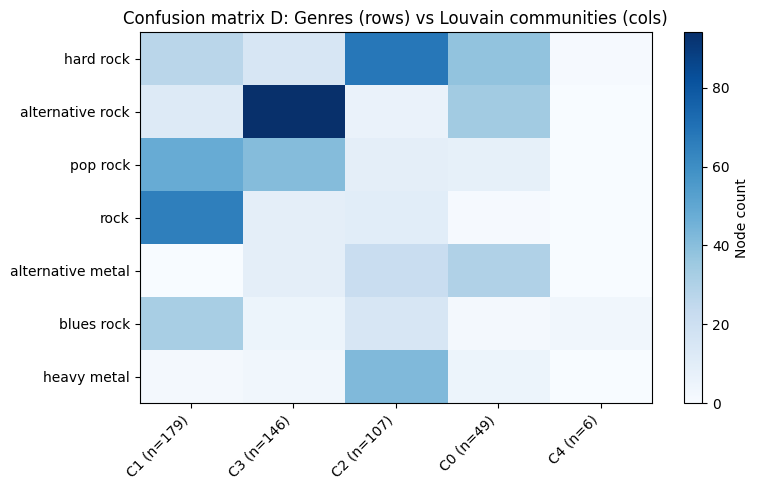

Row totals (per genre): {'hard rock': 149, 'alternative rock': 146, 'pop rock': 106, 'rock': 85, 'alternative metal': 61, 'blues rock': 57, 'heavy metal': 52}
Col totals (per community): {'C1 (n=179)': 186, 'C3 (n=146)': 176, 'C2 (n=107)': 172, 'C0 (n=49)': 118, 'C4 (n=6)': 4}


In [47]:
import numpy as np
import pandas as pd
from collections import Counter

# ------------------------
# Select top-7 genres and top-7 communities
# ------------------------
genre_counts = Counter(
    g
    for n in G_sub.nodes()
    for g in artist_genres.get(n, [])
)
top_genres = [g for g, _ in genre_counts.most_common(7)]

# community sizes over G_sub
comm_counts = Counter(comm_label[n] for n in G_sub.nodes() if n in comm_label)
top_comm_ids = [cid for cid, _ in comm_counts.most_common(7)]

# index maps
g2i = {g:i for i, g in enumerate(top_genres)}
c2j = {cid:j for j, cid in enumerate(top_comm_ids)}

# ------------------------
# Build confusion matrix D (G x C)
#    D[i,j] = #nodes that belong to community j and have genre i
#    (A node with multiple top genres contributes to multiple rows.)
# ------------------------
D = np.zeros((len(top_genres), len(top_comm_ids)), dtype=int)

for n in G_sub.nodes():
    cid = comm_label.get(n)
    if cid not in c2j:          # ignore nodes outside top-7 communities
        continue
    genres = artist_genres.get(n, [])
    any_top = False
    for g in genres:
        if g in g2i:
            D[g2i[g], c2j[cid]] += 1
            any_top = True
    # If node has no top-7 genres -> ignore

# ------------------------
# Confusion matrix table
# ------------------------
col_labels = [f"C{cid} (n={comm_counts[cid]})" for cid in top_comm_ids]
df_D = pd.DataFrame(D, index=top_genres, columns=col_labels)
display(df_D)

# Heatmap
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.imshow(D, aspect="auto", cmap="Blues")
plt.colorbar(label="Node count")
plt.xticks(ticks=range(len(col_labels)), labels=col_labels, rotation=45, ha="right")
plt.yticks(ticks=range(len(top_genres)), labels=top_genres)
plt.title("Confusion matrix D: Genres (rows) vs Louvain communities (cols)")
plt.tight_layout()
plt.show()

# ------------------------
## Summary
# ------------------------
row_sums = D.sum(axis=1)
col_sums = D.sum(axis=0)
print("Row totals (per genre):", dict(zip(top_genres, map(int, row_sums))))
print("Col totals (per community):", dict(zip(col_labels, map(int, col_sums))))

In this step, a confusion matrix was created to compare the seven most common genres with the seven largest structural communities detected by the Louvain algorithm. Each cell in the matrix shows how many artists belong both to a given genre and to a given community, allowing a direct comparison between genre-based and structure-based groupings.

From the matrix and heatmap, it can be seen that some communities correspond fairly well to specific genres — for example, alternative rock aligns strongly with one community, and hard rock or rock show moderate concentration in others. However, the overlap across several columns for most genres indicates that communities are not perfectly aligned with genre labels.

This result is consistent with the modularity values found earlier: while the structural partition (modularity ≈ 0.34) revealed meaningful community structure, the genre-based partition (modularity ≈ 0.09) was much weaker. The confusion matrix confirms that structural communities capture patterns in the network that go beyond simple genre classification — suggesting that connections among artists are influenced by broader factors than genre alone, such as collaborations, shared eras, or stylistic overlap within rock subgenres.